In [43]:
#import libraries
import numpy as np
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import matplotlib
import datetime

In [44]:
#initial values
window_of_days = 30 #fixed rate
shape = [window_of_days, 4, 1] #high, low, open, close
neural_net = [256, 256, 32, 1] #fixed rate
dropout_rate = 0.2 #independent variable
decay = 0.2 #independent variable
epochs = 50 #independent variable
stock_name = "AAPL"

In [45]:
def tune_params(stock_name, window_of_days, dropout_rate, shape, neural_net, epochs, decay):
    df = retrieve_data(stock_name)
    X_train, y_train, X_test, y_test = prep_model(df, window_of_days)
    model = build_model(shape)
    history = model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.2, verbose=0)
    trainScore, testScore = evaluation(model, X_train, y_train, X_test, y_test)
    print("Test " + str(test) + " complete")
    return trainScore, testScore

In [46]:
def retrieve_data(stock_name, moving_avg = []):
    #over 20 years worth of data (from start of century)
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()

    #access yahoo finance database
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Adj Close'], 1, inplace = True)
    df.drop(['Volume'], 1, inplace = True)

    #normalize ranges from values 0 - 1
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

In [47]:
def prep_model(stock, window_of_days):
    feature_count = len(stock.columns)
    print ("Feature count = {}".format(feature_count))
    data = stock.to_numpy() 
    sequence_length = window_of_days + 1
    result = []
    
    for i in range(len(data) - sequence_length):
        result.append(data[i: i + sequence_length]) 
    
    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split train and test data
    print ("Amount of training data = {}".format(0.9 * result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * result.shape[0]))

    #training set
    train = result[:int(row), :] 
    x_train = train[:, :-1] #gets first set of parameters (training data) 
    y_train = train[:, -1][:,-1] #final output of training data values 
    
    #testing set
    x_test = result[int(row):, :-1] #gets last set of parameters (testing data)
    y_test = result[int(row):, -1][:,-1] #final day output

    #reshaping train and test
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature_count))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature_count))  

    return [x_train, y_train, x_test, y_test]

In [48]:
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(neural_net[0], input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
        
    model.add(LSTM(neural_net[1], input_shape=(layers[0], layers[1]), return_sequences=False))
    model.add(Dropout(dropout_rate))
        
    model.add(Dense(neural_net[2], kernel_initializer="uniform", activation='relu'))        
    model.add(Dense(neural_net[3], kernel_initializer="uniform", activation='linear'))

    adam = keras.optimizers.Adam(decay = decay)
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    return model

In [49]:
def evaluation(model, X_train, y_train, X_test, y_test):
  trainScore = model.evaluate(X_train, y_train, verbose=0)
  print('Train Score\n----------\n%.5f MSE \n%.2f RMSE' % (trainScore[0], math.sqrt(trainScore[0])))

  testScore = model.evaluate(X_test, y_test, verbose=0)
  print('\nTest Score\n----------\n%.5f MSE \n%.2f RMSE' % (testScore[0], math.sqrt(testScore[0])))
  return trainScore[0], testScore[0]

In [33]:
#epoch testing
epoch_tests = [2,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

train_result = {}
test_result = {}

for test in epoch_tests:    
    trainScore, testScore = tune_params(stock_name, window_of_days, dropout_rate, shape, neural_net, test, decay)
    train_result[test] = trainScore
    test_result[test] = testScore

Feature count = 4
Amount of training data = 4627.8
Amount of testing data = 514.2
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 30, 256)           267264    
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 800,833
Trainable param

In [34]:
min_train = min(train_result.values())
min_train_key = [k for k, v in train_result.items() if v == min_train]
print (train_result)
print (min_train_key)

{2: 0.004449941789652702, 10: 8.985640957844584e-05, 20: 5.881368608772563e-05, 30: 5.4506398937932815e-05, 40: 4.690435259645167e-05, 50: 2.60397510886325e-05, 60: 2.5157411091855266e-05, 70: 2.7623387534017497e-05, 80: 2.4064641201361252e-05, 90: 3.8276558986376065e-05, 100: 3.885129176453317e-05, 110: 2.1492323544856885e-05, 120: 2.0256732213183136e-05, 130: 2.0120247213258955e-05, 140: 3.1445131776562936e-05, 150: 1.7982205324174995e-05}
[150]


In [35]:
min_test = min(test_result.values())
min_test_key = [k for k, v in test_result.items() if v == min_test]
print (test_result)
print (min_test_key)

{2: 0.1049172822023644, 10: 0.029509840310272192, 20: 0.02372348123748247, 30: 0.02042087849006709, 40: 0.010507390632815949, 50: 0.007134523890923404, 60: 0.00612353551557563, 70: 0.007144432269165416, 80: 0.004469804521487004, 90: 0.0044156651593317145, 100: 0.003417992839365038, 110: 0.0033367010722877206, 120: 0.0019481222131443555, 130: 0.0032284207563260245, 140: 0.0011816408987923032, 150: 0.002276497416276166}
[140]


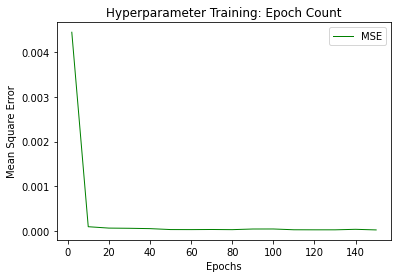

In [37]:
import matplotlib.pyplot as plt

lists2 = sorted(train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2, y2, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Training: Epoch Count')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

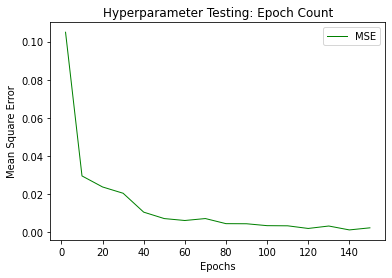

In [38]:
list1 = sorted(test_result.items())
x1,y1 = zip(*list1)
plt.plot(x1, y1, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Testing: Epoch Count')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

In [50]:
#Testing for dropout
dropout_tests = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
train_result = {}
test_result = {}
for test in dropout_tests:    
    trainScore, testScore = tune_params(stock_name, window_of_days, test, shape, neural_net, epochs, decay)
    train_result[test] = trainScore
    test_result[test] = testScore

Feature count = 4
Amount of training data = 4627.8
Amount of testing data = 514.2
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 30, 256)           267264    
_________________________________________________________________
dropout_65 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 800,833
Trainable param

In [51]:
min_train = min(train_result.values())
min_train_key = [k for k, v in train_result.items() if v == min_train]
print (train_result)
print (min_train_key)

{0.2: 4.024887104417033e-05, 0.3: 3.2370280231873686e-05, 0.4: 0.00010350907029584407, 0.5: 2.905153734960102e-05, 0.6: 4.099016316324508e-05, 0.7: 3.7076942515528686e-05, 0.8: 3.498645040307574e-05}
[0.5]


In [52]:
min_test = min(test_result.values())
min_test_key = [k for k, v in test_result.items() if v == min_test]
print (test_result)
print (min_test_key)

{0.2: 0.009958471113123753, 0.3: 0.0059851832524329745, 0.4: 0.014340149173476816, 0.5: 0.008283630017089705, 0.6: 0.008988403823907969, 0.7: 0.007112382481496144, 0.8: 0.011184329952019111}
[0.3]


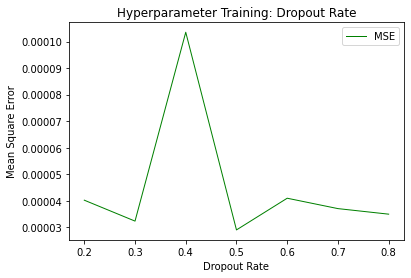

In [54]:
lists2 = sorted(train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2, y2, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Training: Dropout Rate')
plt.legend(loc='best')
plt.xlabel('Dropout Rate')
plt.ylabel('Mean Square Error')
plt.show()

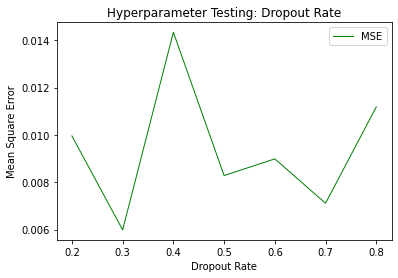

In [56]:
list1 = sorted(test_result.items())
x1,y1 = zip(*list1)
plt.plot(x1, y1, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Testing: Dropout Rate')
plt.legend(loc='best')
plt.xlabel('Dropout Rate')
plt.ylabel('Mean Square Error')
plt.show()

In [60]:
#Testing for decay
decay_tests = [0.1, 0.2, 0.3, 0.4]
train_result = {}
test_result = {}
for test in decay_tests:    
    trainScore, testScore = tune_params(stock_name, window_of_days, dropout_rate, shape, neural_net, epochs, test)
    train_result[test] = trainScore
    test_result[test] = testScore

Feature count = 4
Amount of training data = 4627.8
Amount of testing data = 514.2
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 30, 256)           267264    
_________________________________________________________________
dropout_79 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 33        
Total params: 800,833
Trainable param

In [61]:
min_train = min(train_result.values())
min_train_key = [k for k, v in train_result.items() if v == min_train]
print (train_result)
print (min_train_key)

{0.1: 5.724377940337789e-05, 0.2: 3.5333839687194215e-05, 0.3: 3.409394532073355e-05, 0.4: 5.5935502820930074e-05}
[0.3]


In [62]:
min_test = min(test_result.values())
min_test_key = [k for k, v in test_result.items() if v == min_test]
print (test_result)
print (min_test_key)

{0.1: 0.010672477790578503, 0.2: 0.012281231778983664, 0.3: 0.011023875883986978, 0.4: 0.011806603543757522}
[0.1]


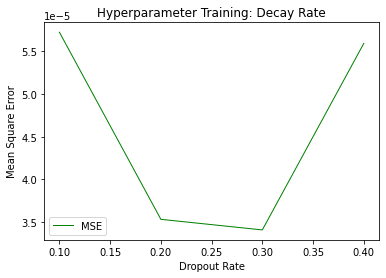

In [63]:
lists2 = sorted(train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2, y2, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Training: Decay Rate')
plt.legend(loc='best')
plt.xlabel('Dropout Rate')
plt.ylabel('Mean Square Error')
plt.show()

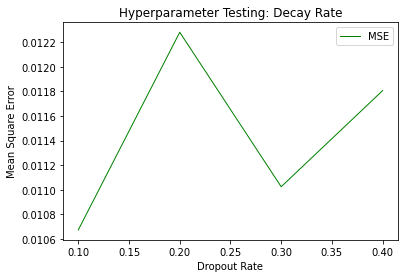

In [64]:
list1 = sorted(test_result.items())
x1,y1 = zip(*list1)
plt.plot(x1, y1, linewidth = 1, label = 'MSE', color = "green")
plt.title('Hyperparameter Testing: Decay Rate')
plt.legend(loc='best')
plt.xlabel('Dropout Rate')
plt.ylabel('Mean Square Error')
plt.show()